<a href="https://colab.research.google.com/github/fabehashahzad/reinforcement/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
import pandas as pd
from sklearn.preprocessing import RobustScaler


In [2]:
from google.colab import files
uploaded = files.upload()


Saving london_merged.csv to london_merged.csv


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from sklearn.preprocessing import RobustScaler

df = pd.read_csv('london_merged.csv', parse_dates=['timestamp'],
  index_col="timestamp")

In [4]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month


df.head()


,number_of_swaps,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,
2015-01-04 00:00:00,182,0,1,3,0,4,6,1
2015-01-04 01:00:00,138,0,1,3,1,4,6,1
2015-01-04 02:00:00,134,0,1,3,2,4,6,1
2015-01-04 03:00:00,72,0,1,3,3,4,6,1
2015-01-04 04:00:00,47,0,1,3,4,4,6,1


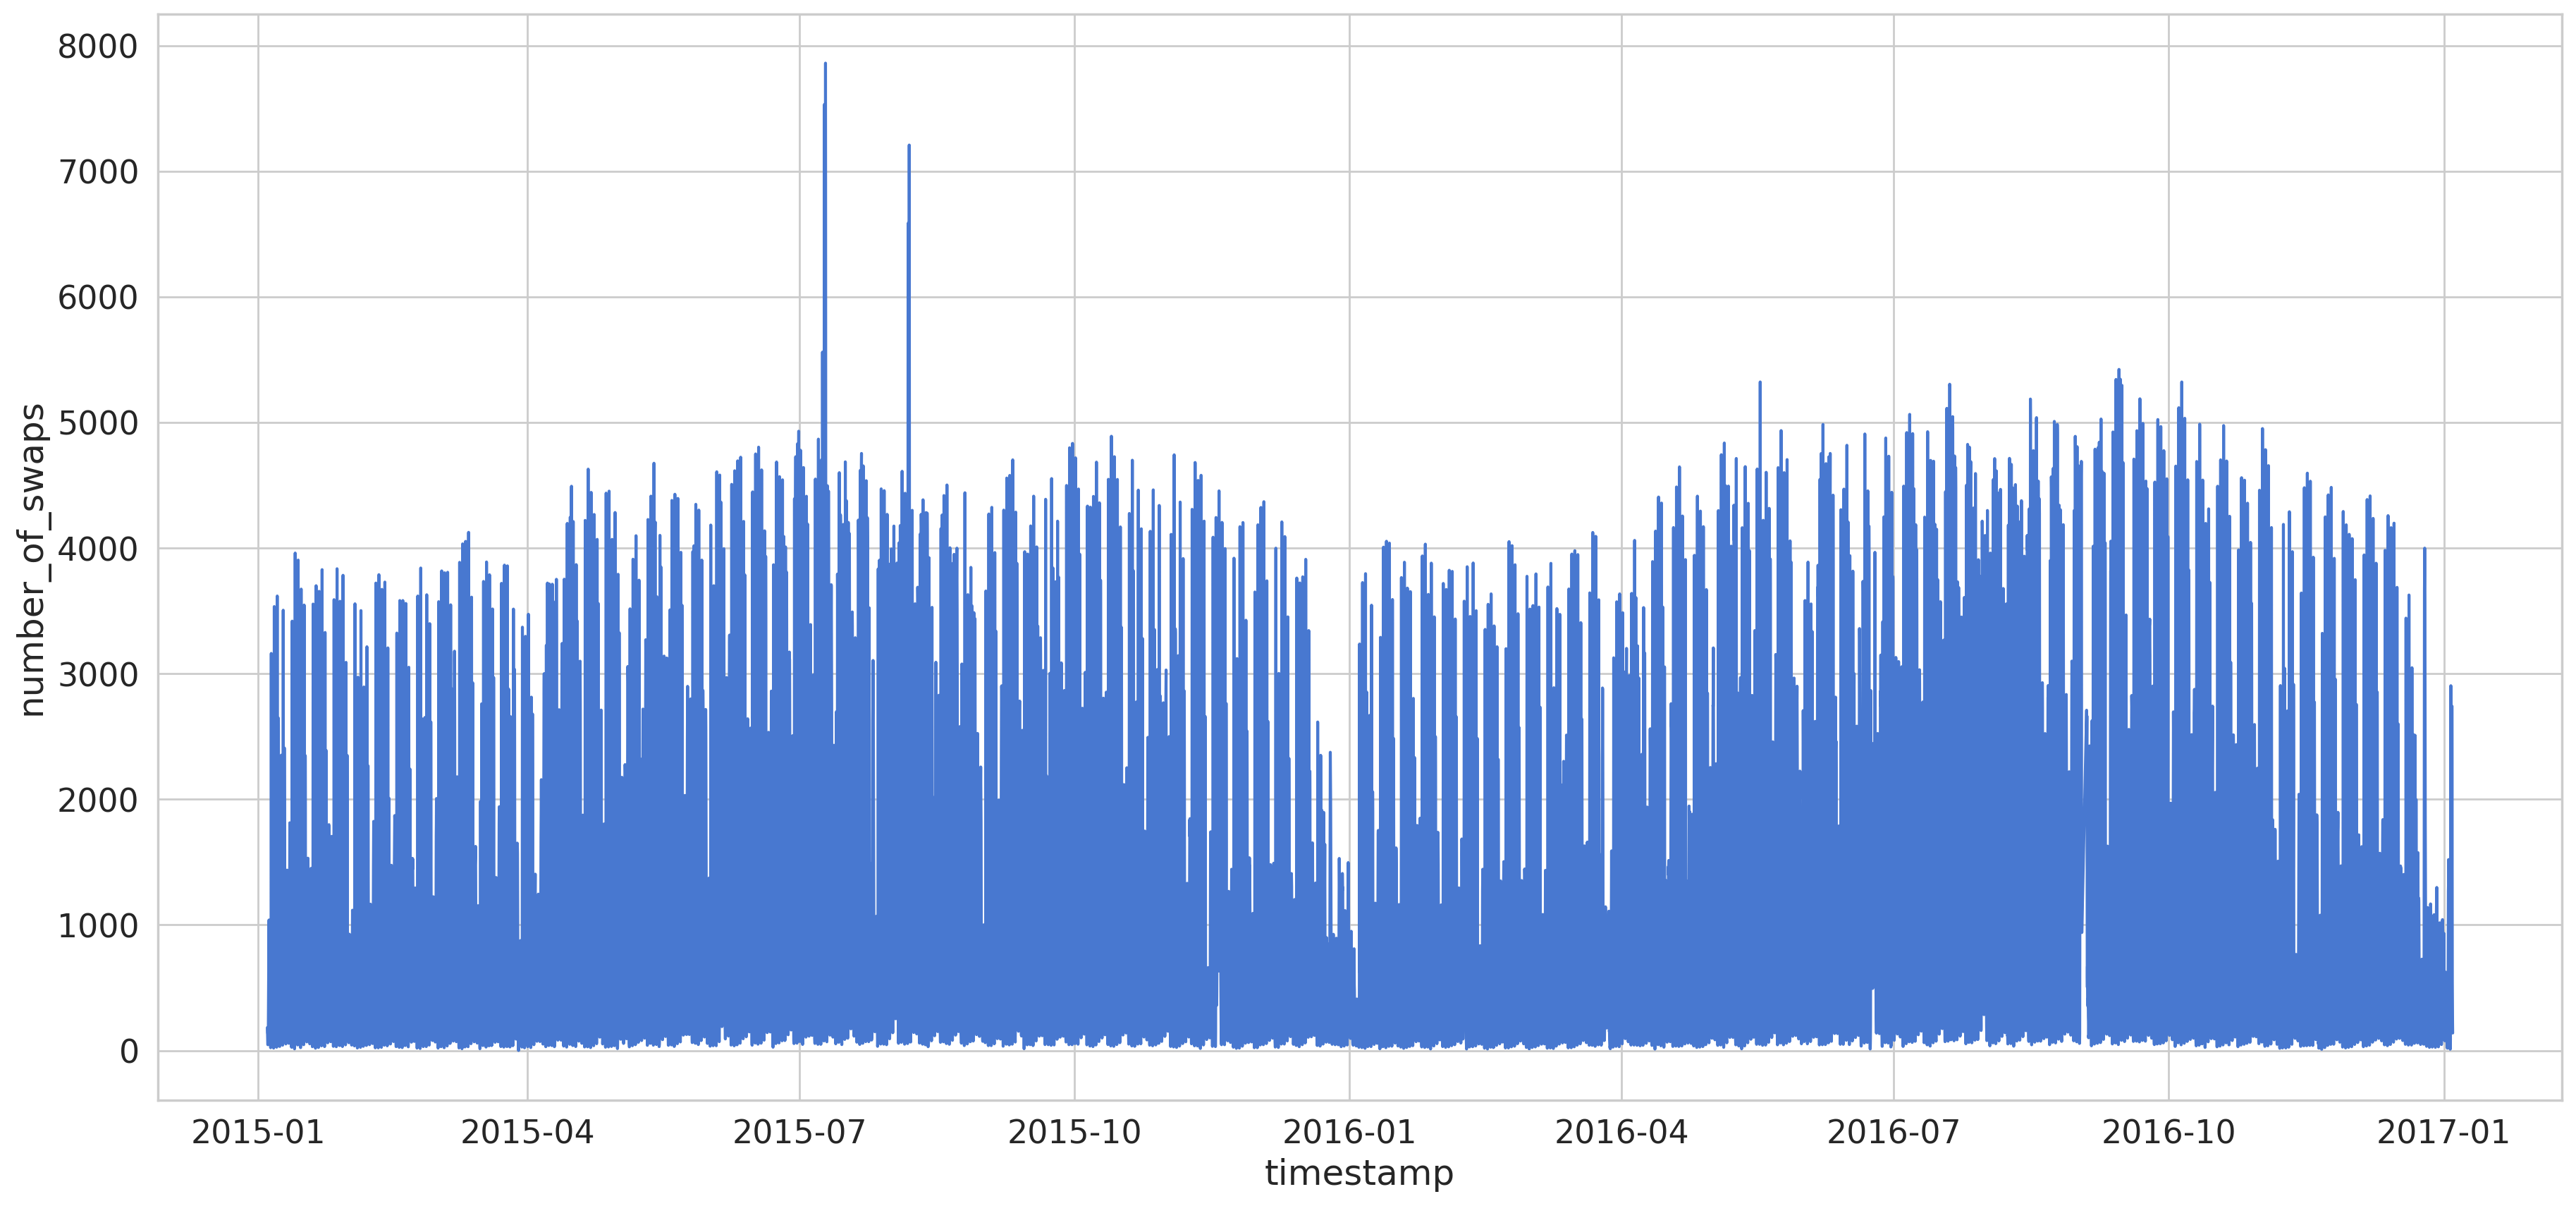

In [5]:
sns.lineplot(x=df.index, y="number_of_swaps", data=df);

In [6]:
df.shape


(17414, 8)

In [7]:
df.head()

,number_of_swaps,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,
2015-01-04 00:00:00,182,0,1,3,0,4,6,1
2015-01-04 01:00:00,138,0,1,3,1,4,6,1
2015-01-04 02:00:00,134,0,1,3,2,4,6,1
2015-01-04 03:00:00,72,0,1,3,3,4,6,1
2015-01-04 04:00:00,47,0,1,3,4,4,6,1


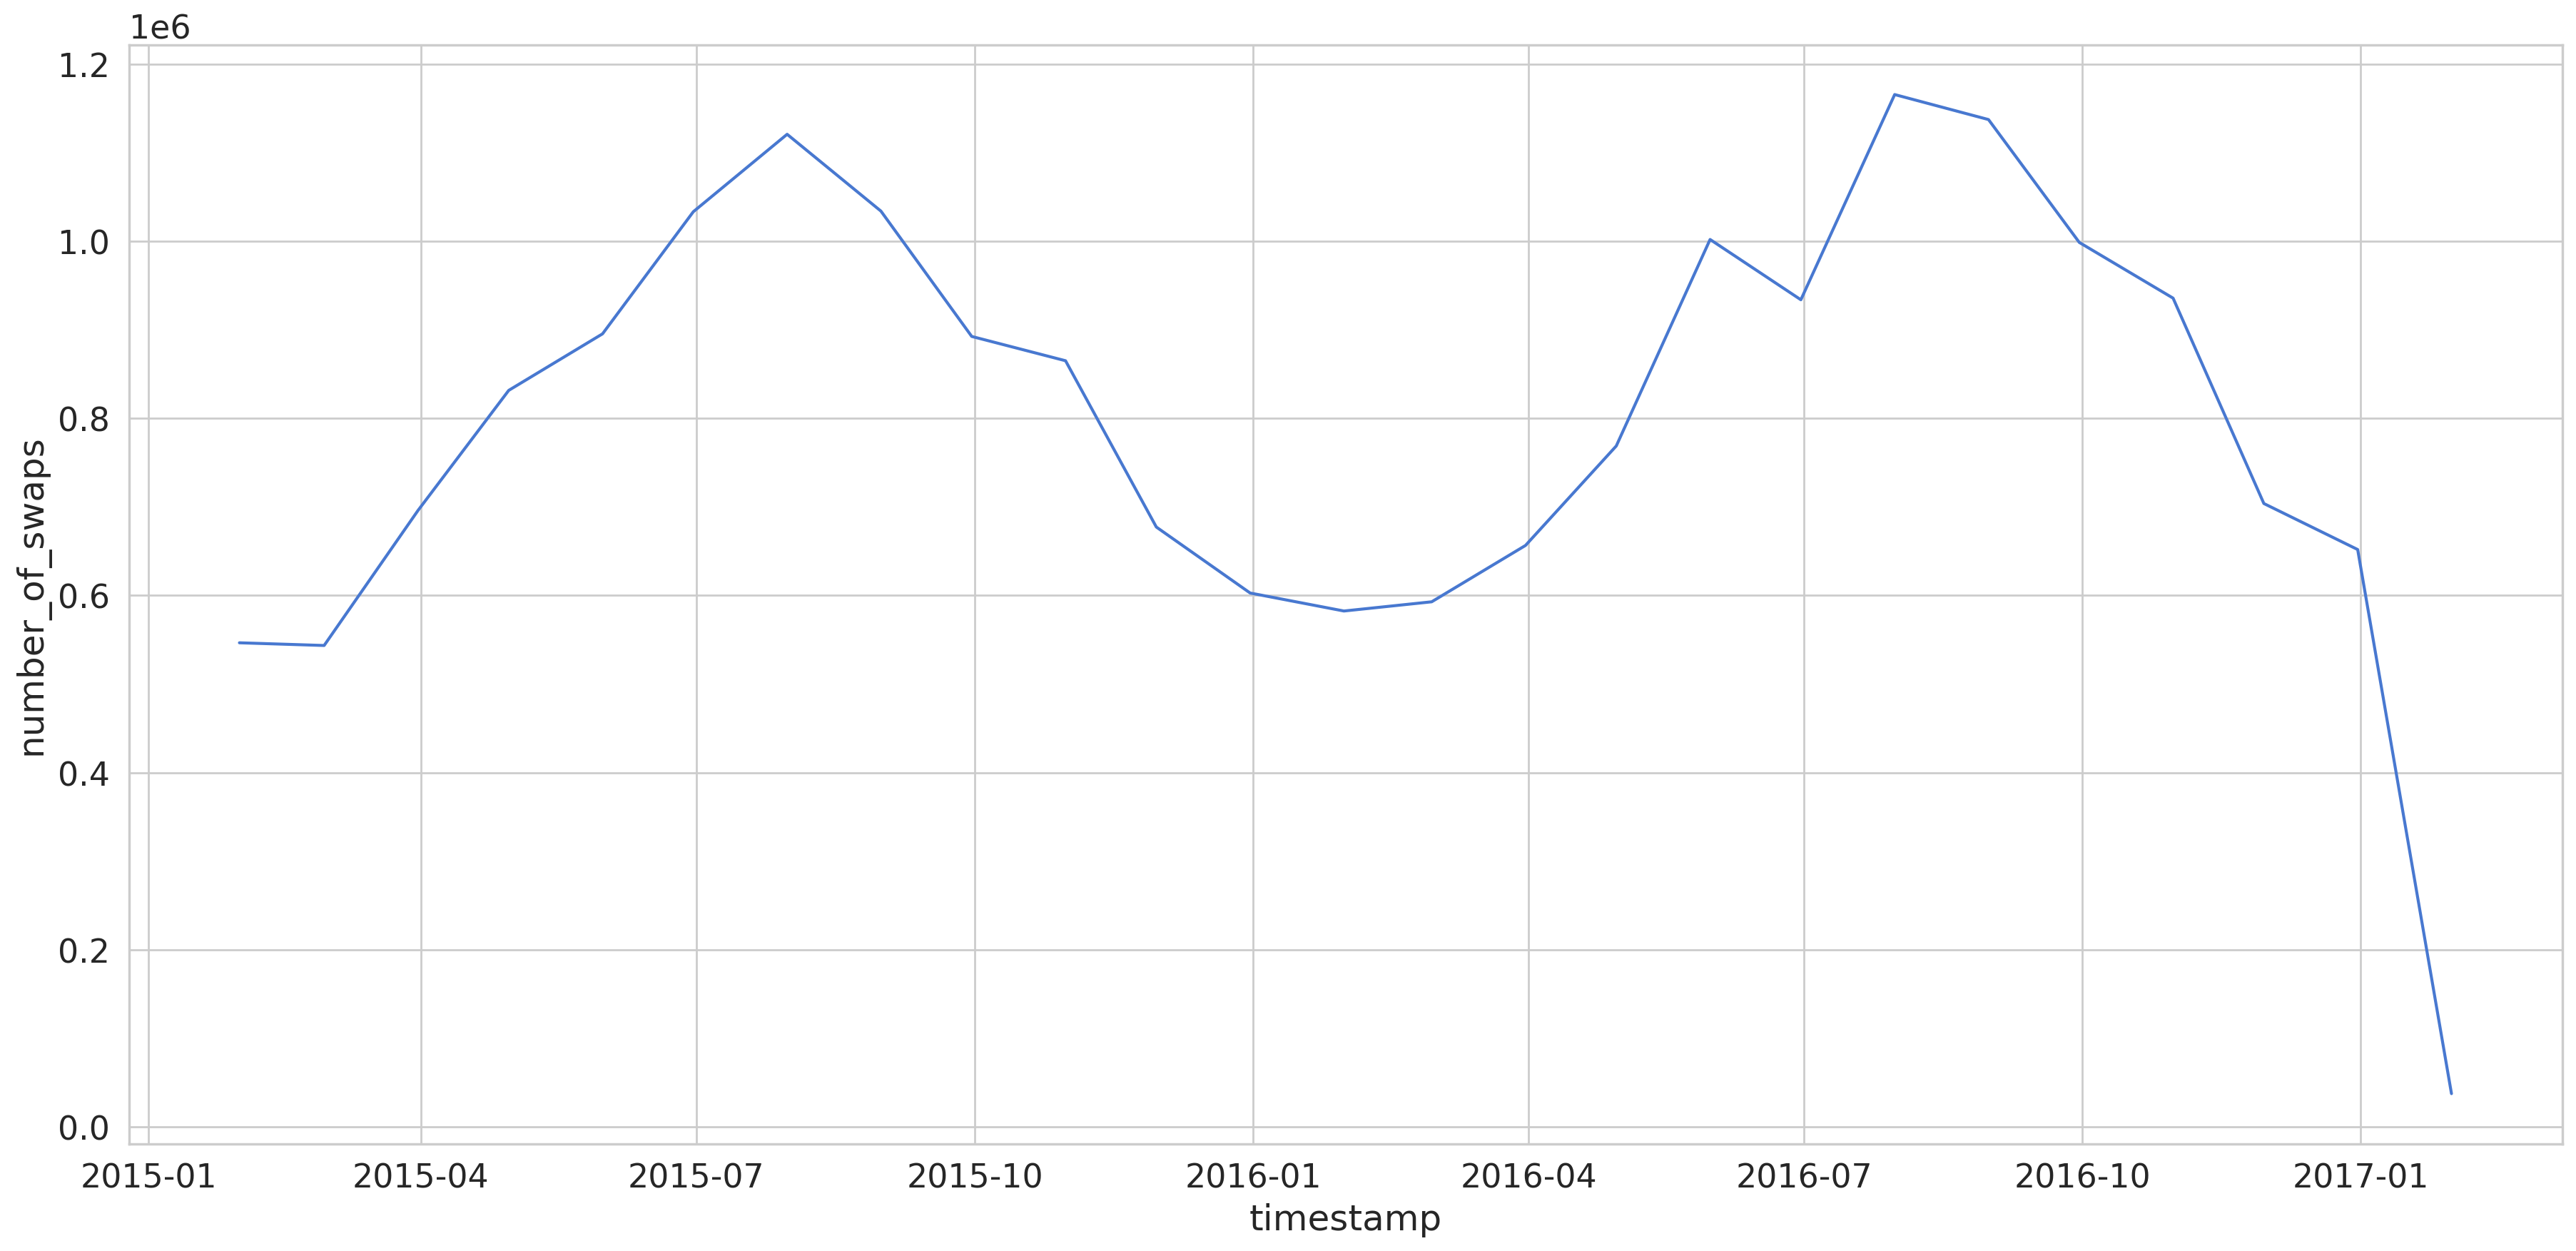

In [11]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="number_of_swaps", data=df_by_month);

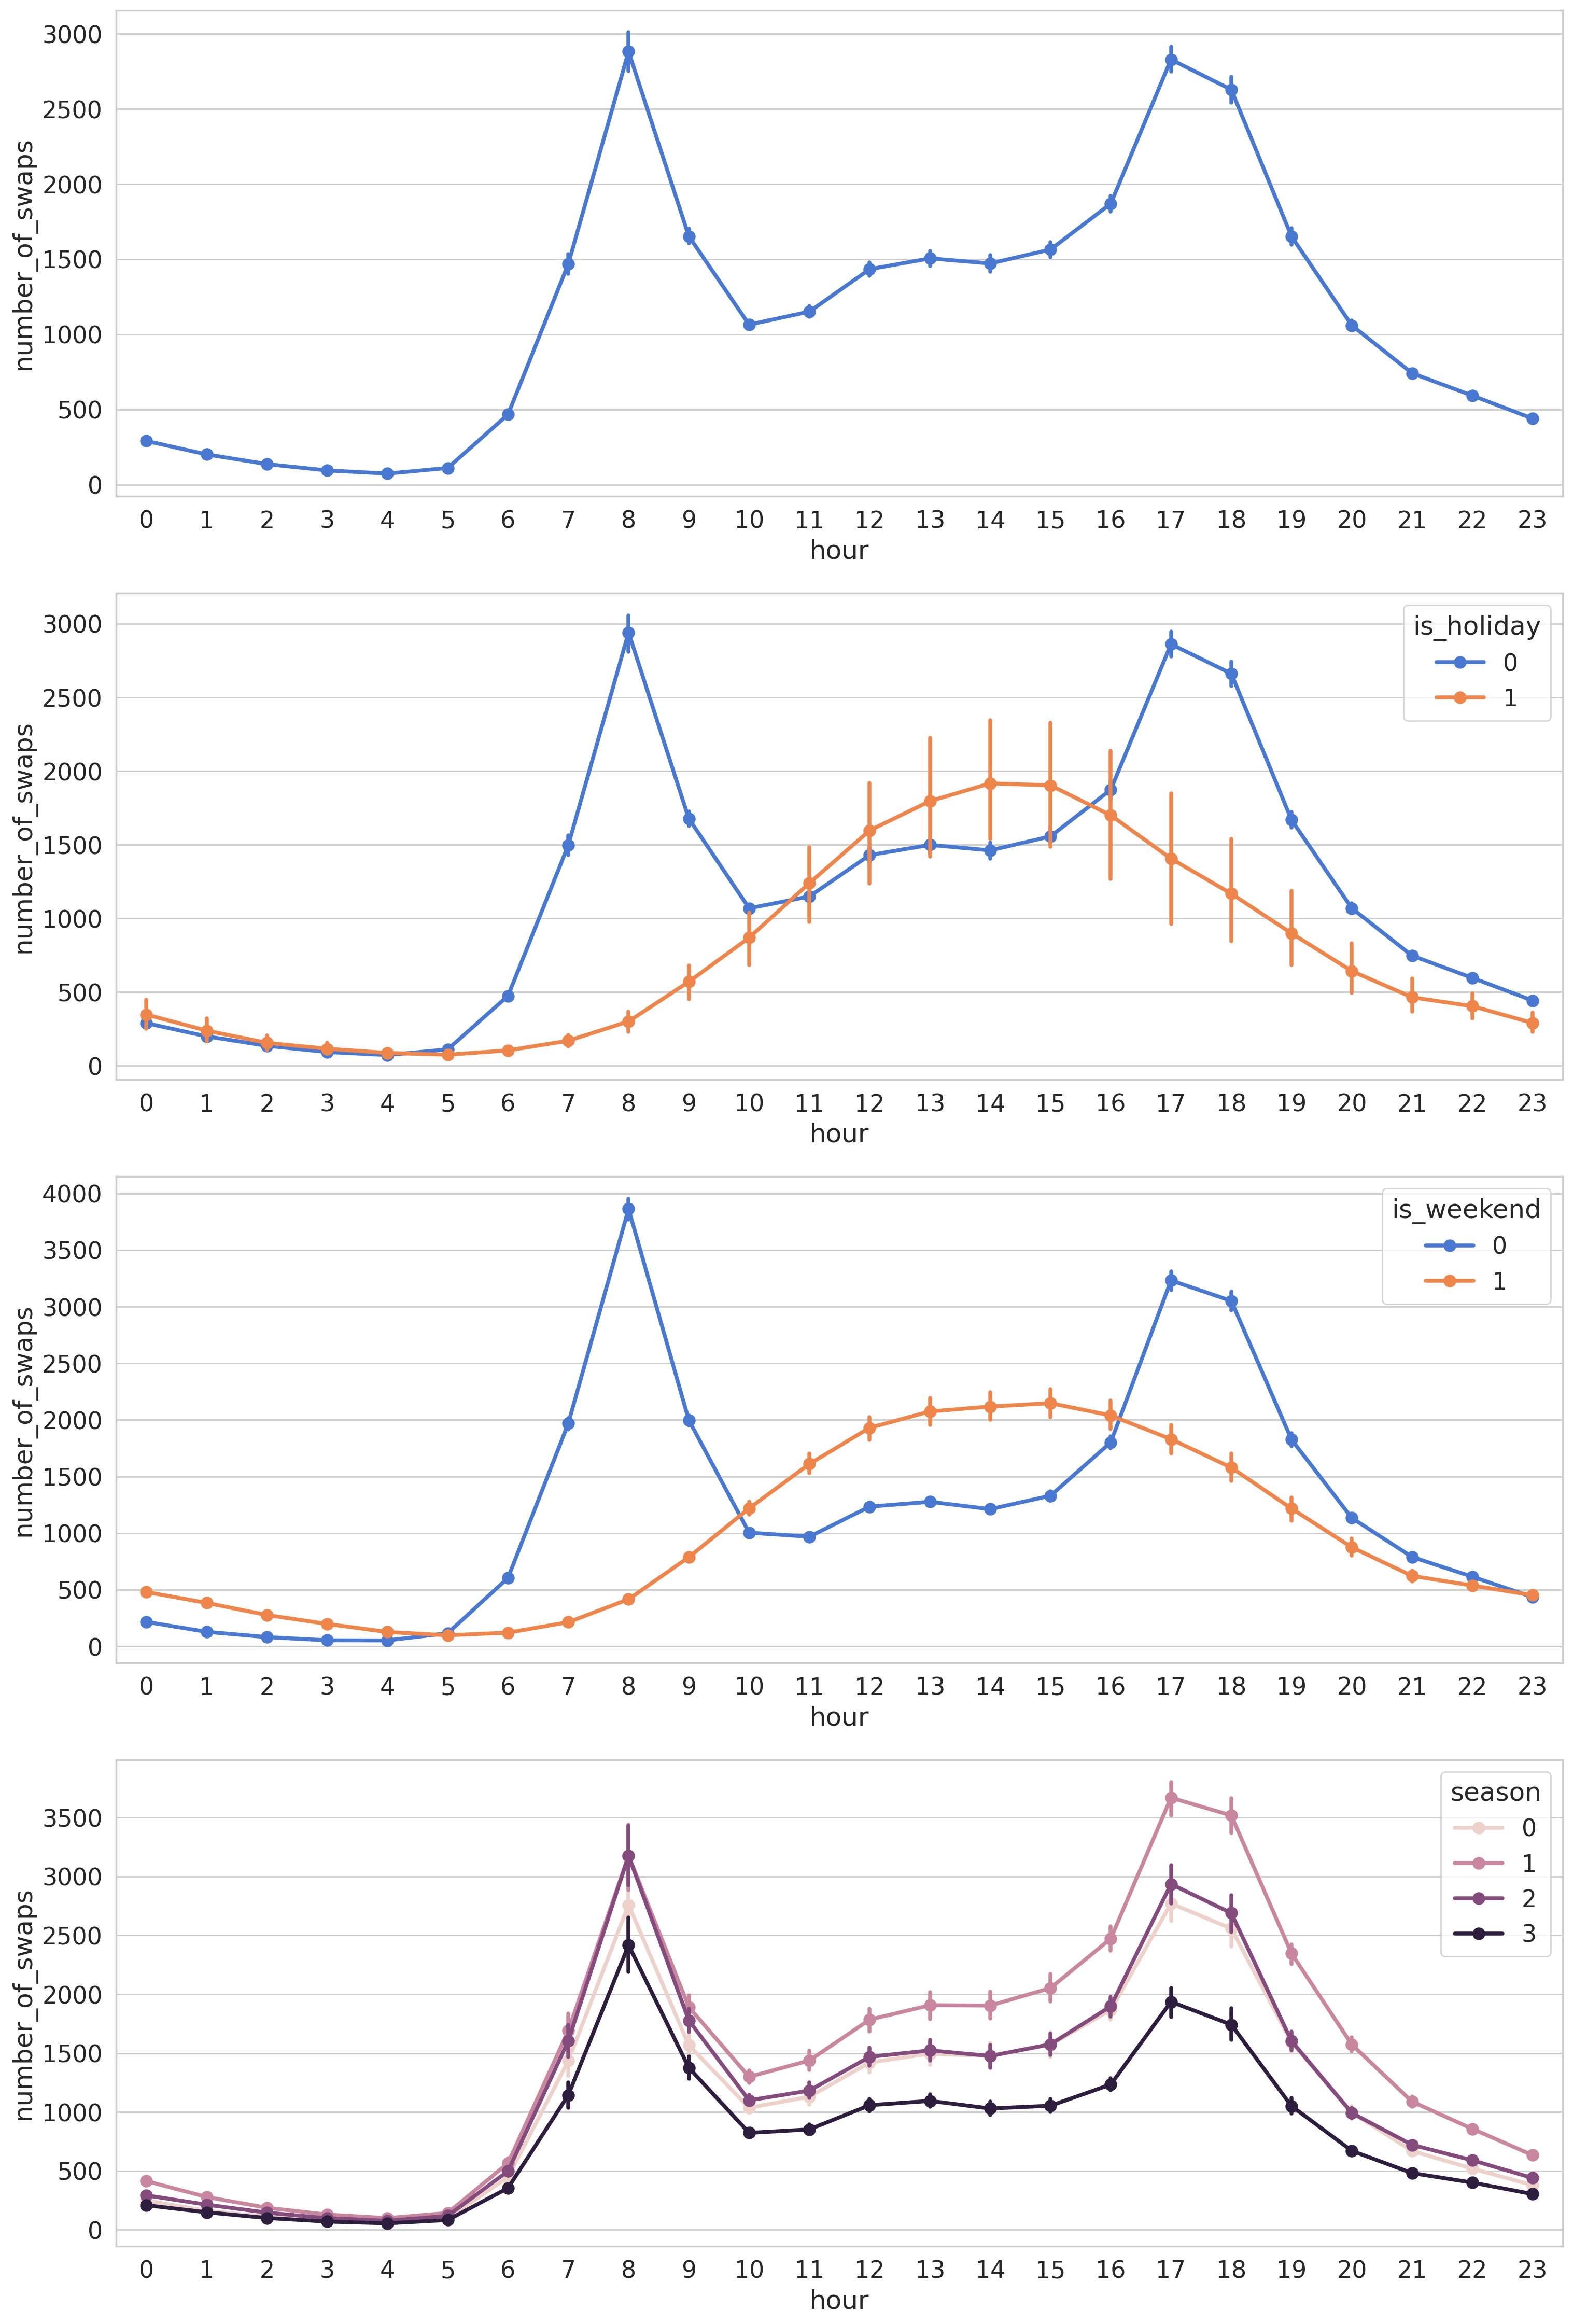

In [12]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='number_of_swaps', ax=ax1)
sns.pointplot(data=df, x='hour', y='number_of_swaps', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='number_of_swaps', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='number_of_swaps', hue='season', ax=ax4);

In [13]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]



In [14]:
f_columns = ['number_of_swaps']

f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train.to_numpy())
train.loc[:] = f_transformer.transform(train.to_numpy())
test.loc[:] = f_transformer.transform(test.to_numpy())
cnt_transformer = RobustScaler()
cnt_transformer = cnt_transformer.fit(train[['number_of_swaps']])
train.loc[:, 'number_of_swaps'] = cnt_transformer.transform(train[['number_of_swaps']])
test.loc[:, 'number_of_swaps'] = cnt_transformer.transform(test[['number_of_swaps']])

<ipython-input-14-e2c1d7132ea5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:] = f_transformer.transform(train.to_numpy())
<ipython-input-14-e2c1d7132ea5>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:] = f_transformer.transform(train.to_numpy())
<ipython-input-14-e2c1d7132ea5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.number_of_swaps, time_steps)
X_test, y_test = create_dataset(test, test.number_of_swaps, time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(13921, 10, 8) (13921,)
(3473, 10, 8) (3473,)


In [19]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
392/392 [==============================] - 10s 18ms/step - loss: 0.1333 - val_loss: 0.0965
Epoch 2/30
392/392 [==============================] - 6s 15ms/step - loss: 0.0476 - val_loss: 0.0572
Epoch 3/30
392/392 [==============================] - 6s 16ms/step - loss: 0.0352 - val_loss: 0.0458
Epoch 4/30
392/392 [==============================] - 6s 15ms/step - loss: 0.0294 - val_loss: 0.0395
Epoch 5/30
392/392 [==============================] - 6s 16ms/step - loss: 0.0260 - val_loss: 0.0354
Epoch 6/30
392/392 [==============================] - 6s 15ms/step - loss: 0.0229 - val_loss: 0.0325
Epoch 7/30
392/392 [==============================] - 6s 16ms/step - loss: 0.0213 - val_loss: 0.0324
Epoch 8/30
392/392 [==============================] - 7s 17ms/step - loss: 0.0205 - val_loss: 0.0315
Epoch 9/30
392/392 [==============================] - 7s 17ms/step - loss: 0.0194 - val_loss: 0.0299
Epoch 10/30
392/392 [==============================] - 6s 15ms/step - loss: 0.0188 - val_l

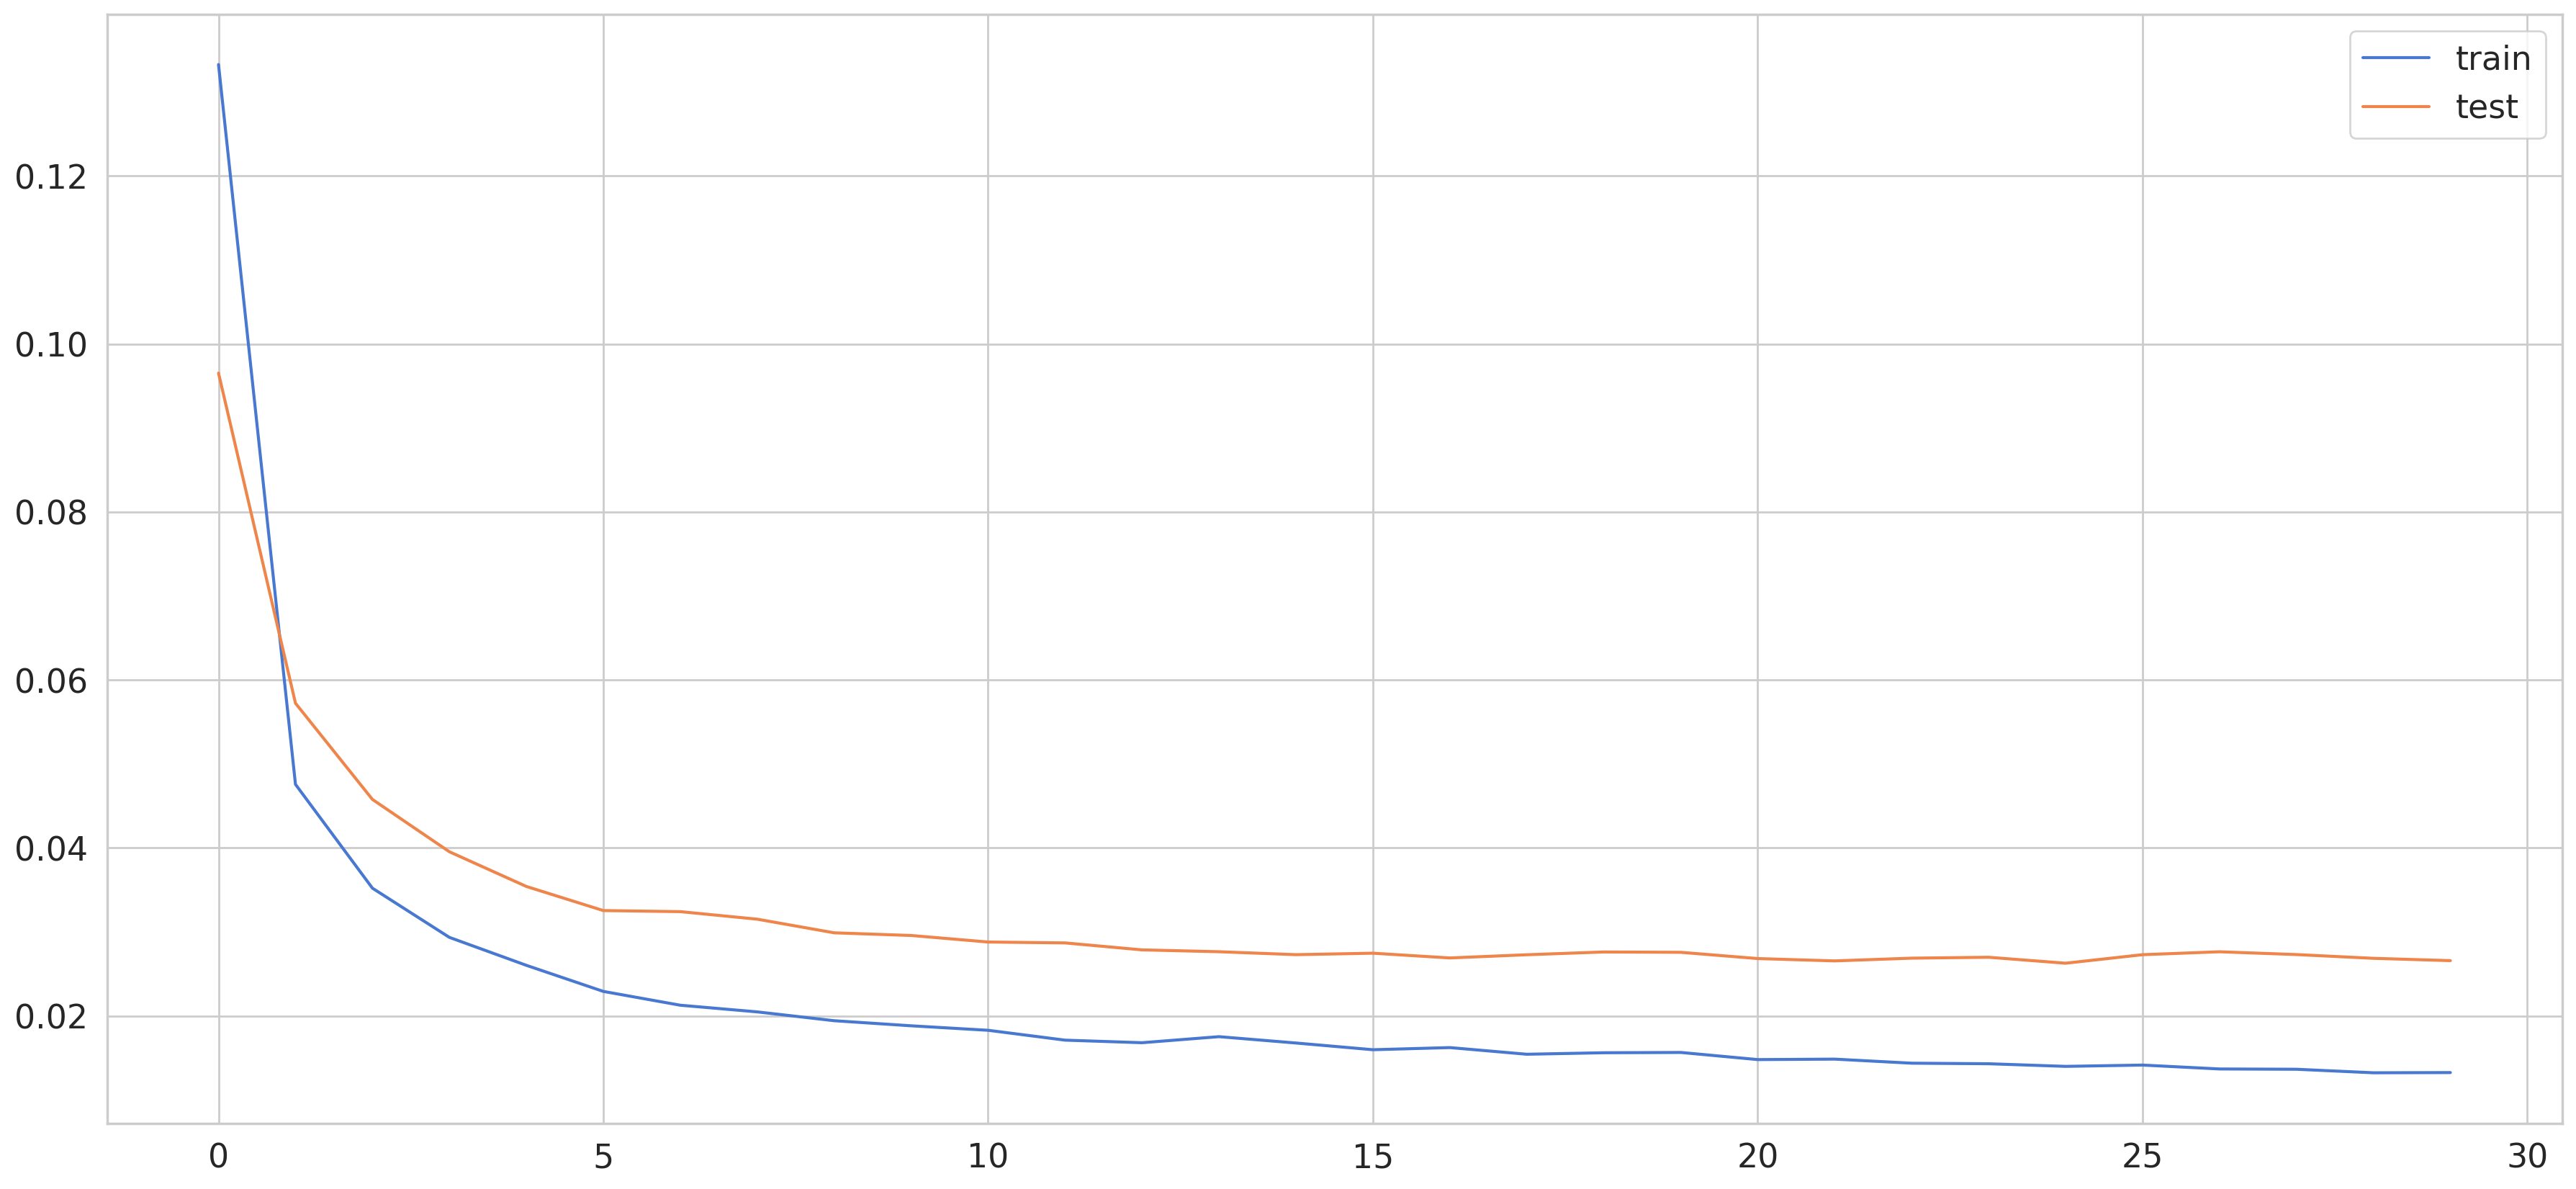

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [24]:
y_pred = model.predict(X_test)

109/109 [==============================] - 1s 5ms/step


In [25]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [26]:
print(y_pred_inv)

[[ 0.49620178]
 [ 0.49352857]
 [ 0.64817786]
 ...
 [-0.29612455]
 [-0.4096702 ]
 [-0.4849188 ]]


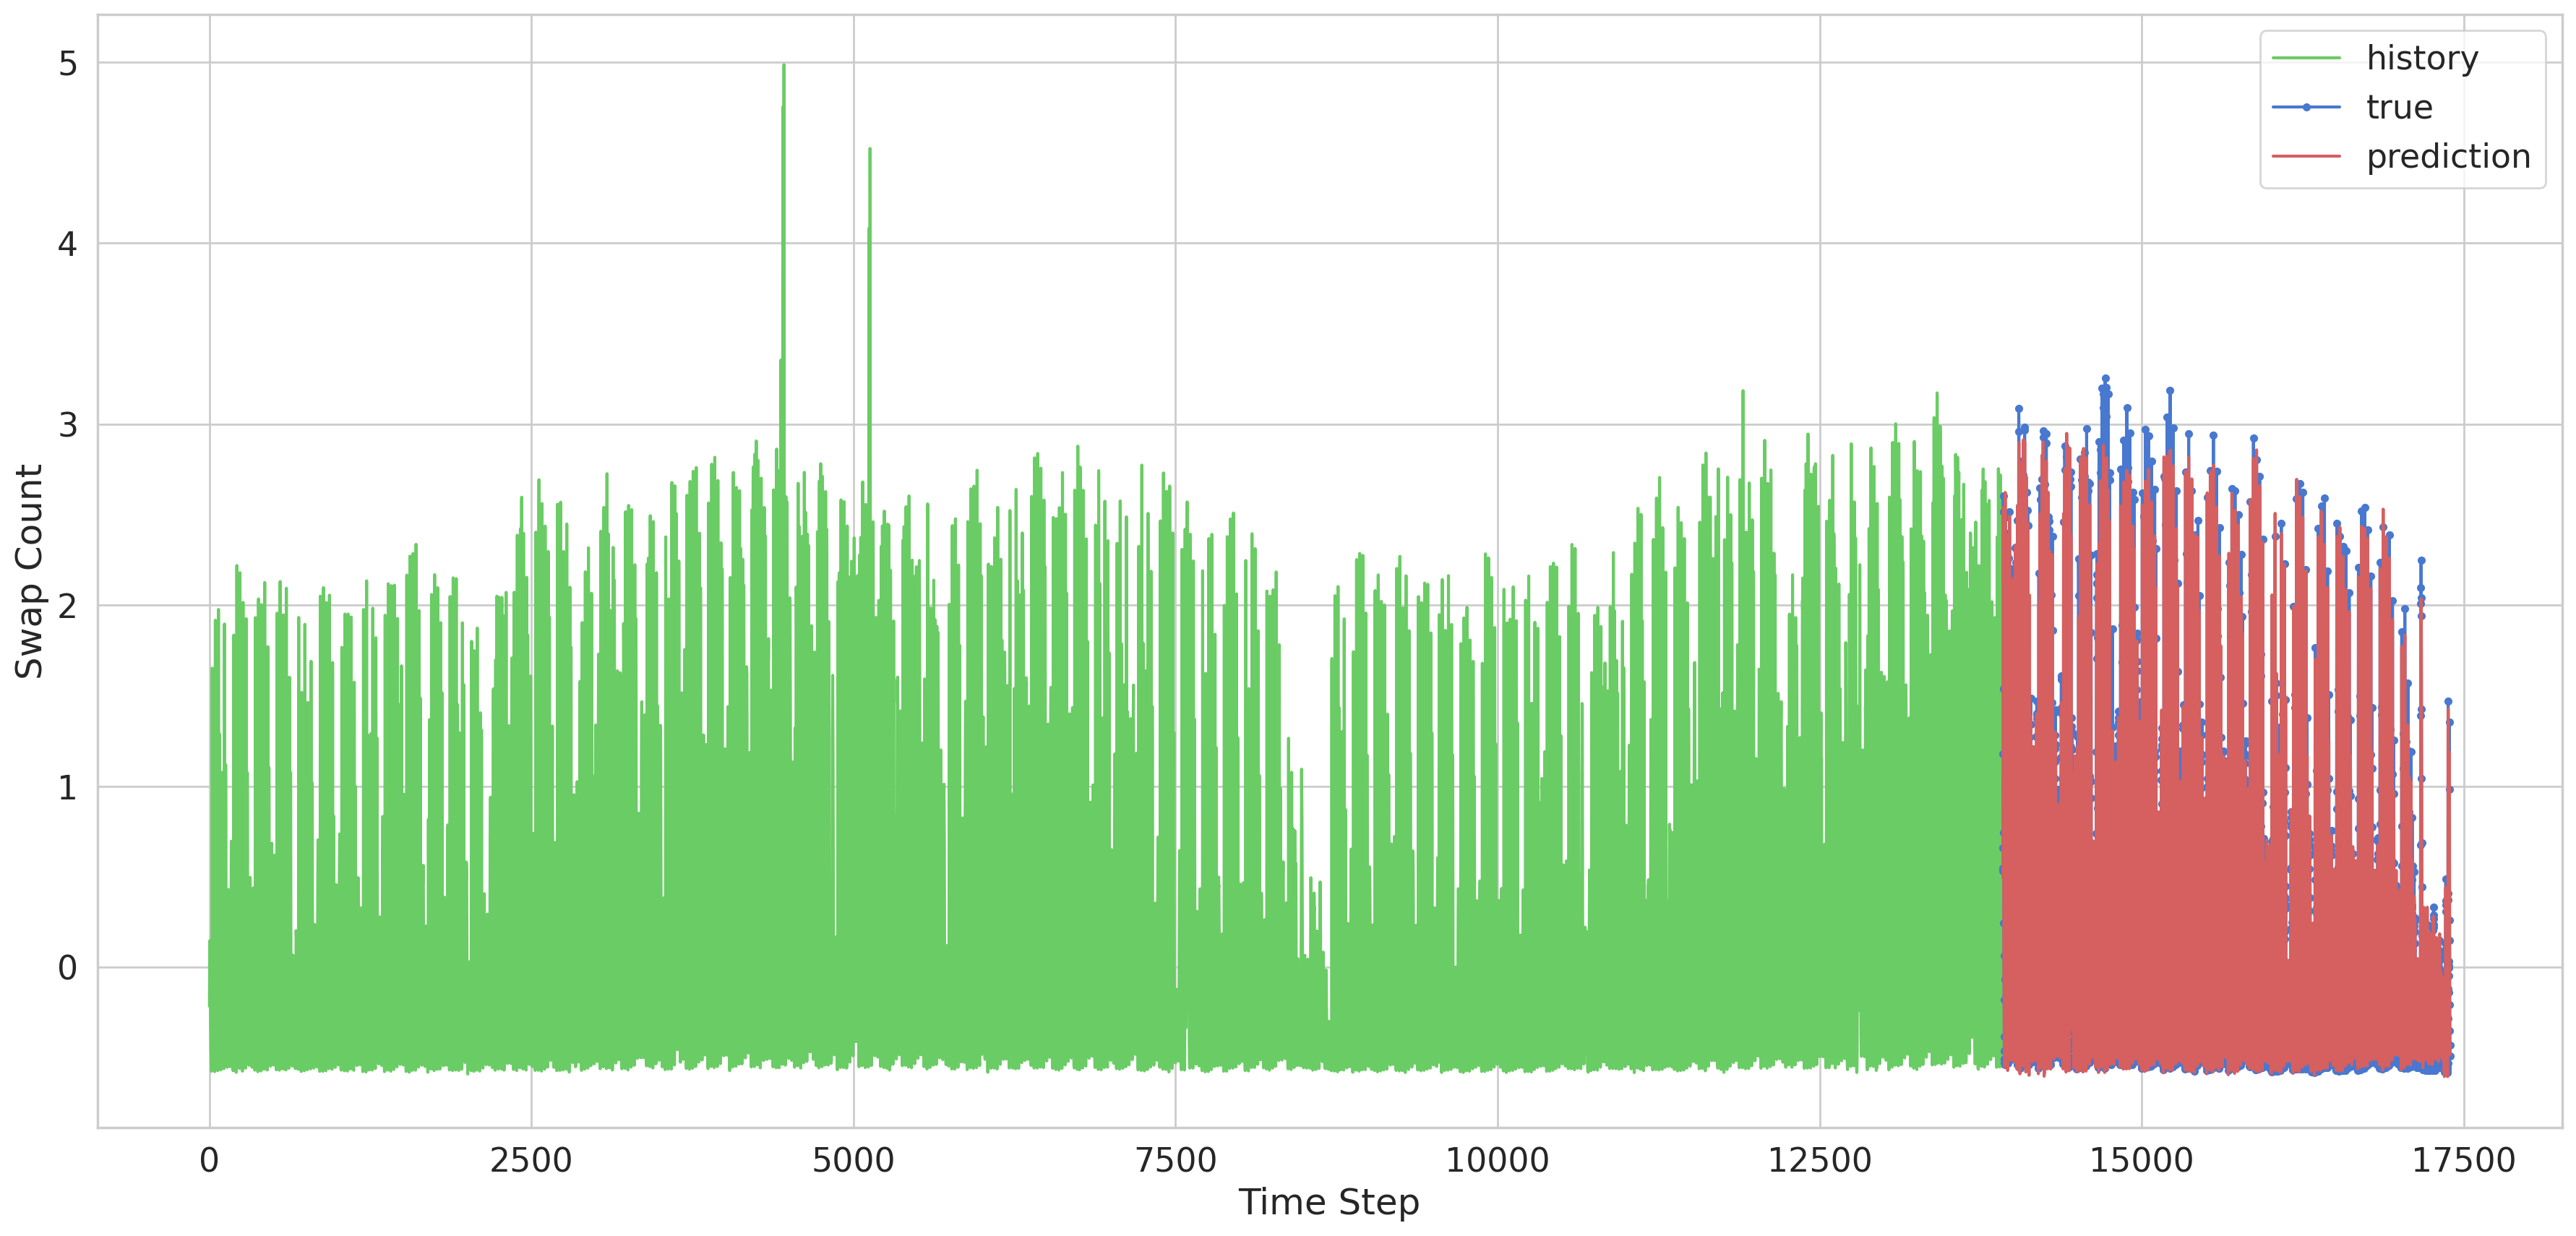

In [27]:

# Round up the values
rounded_up_array = np.ceil(y_pred_inv)
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Swap Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

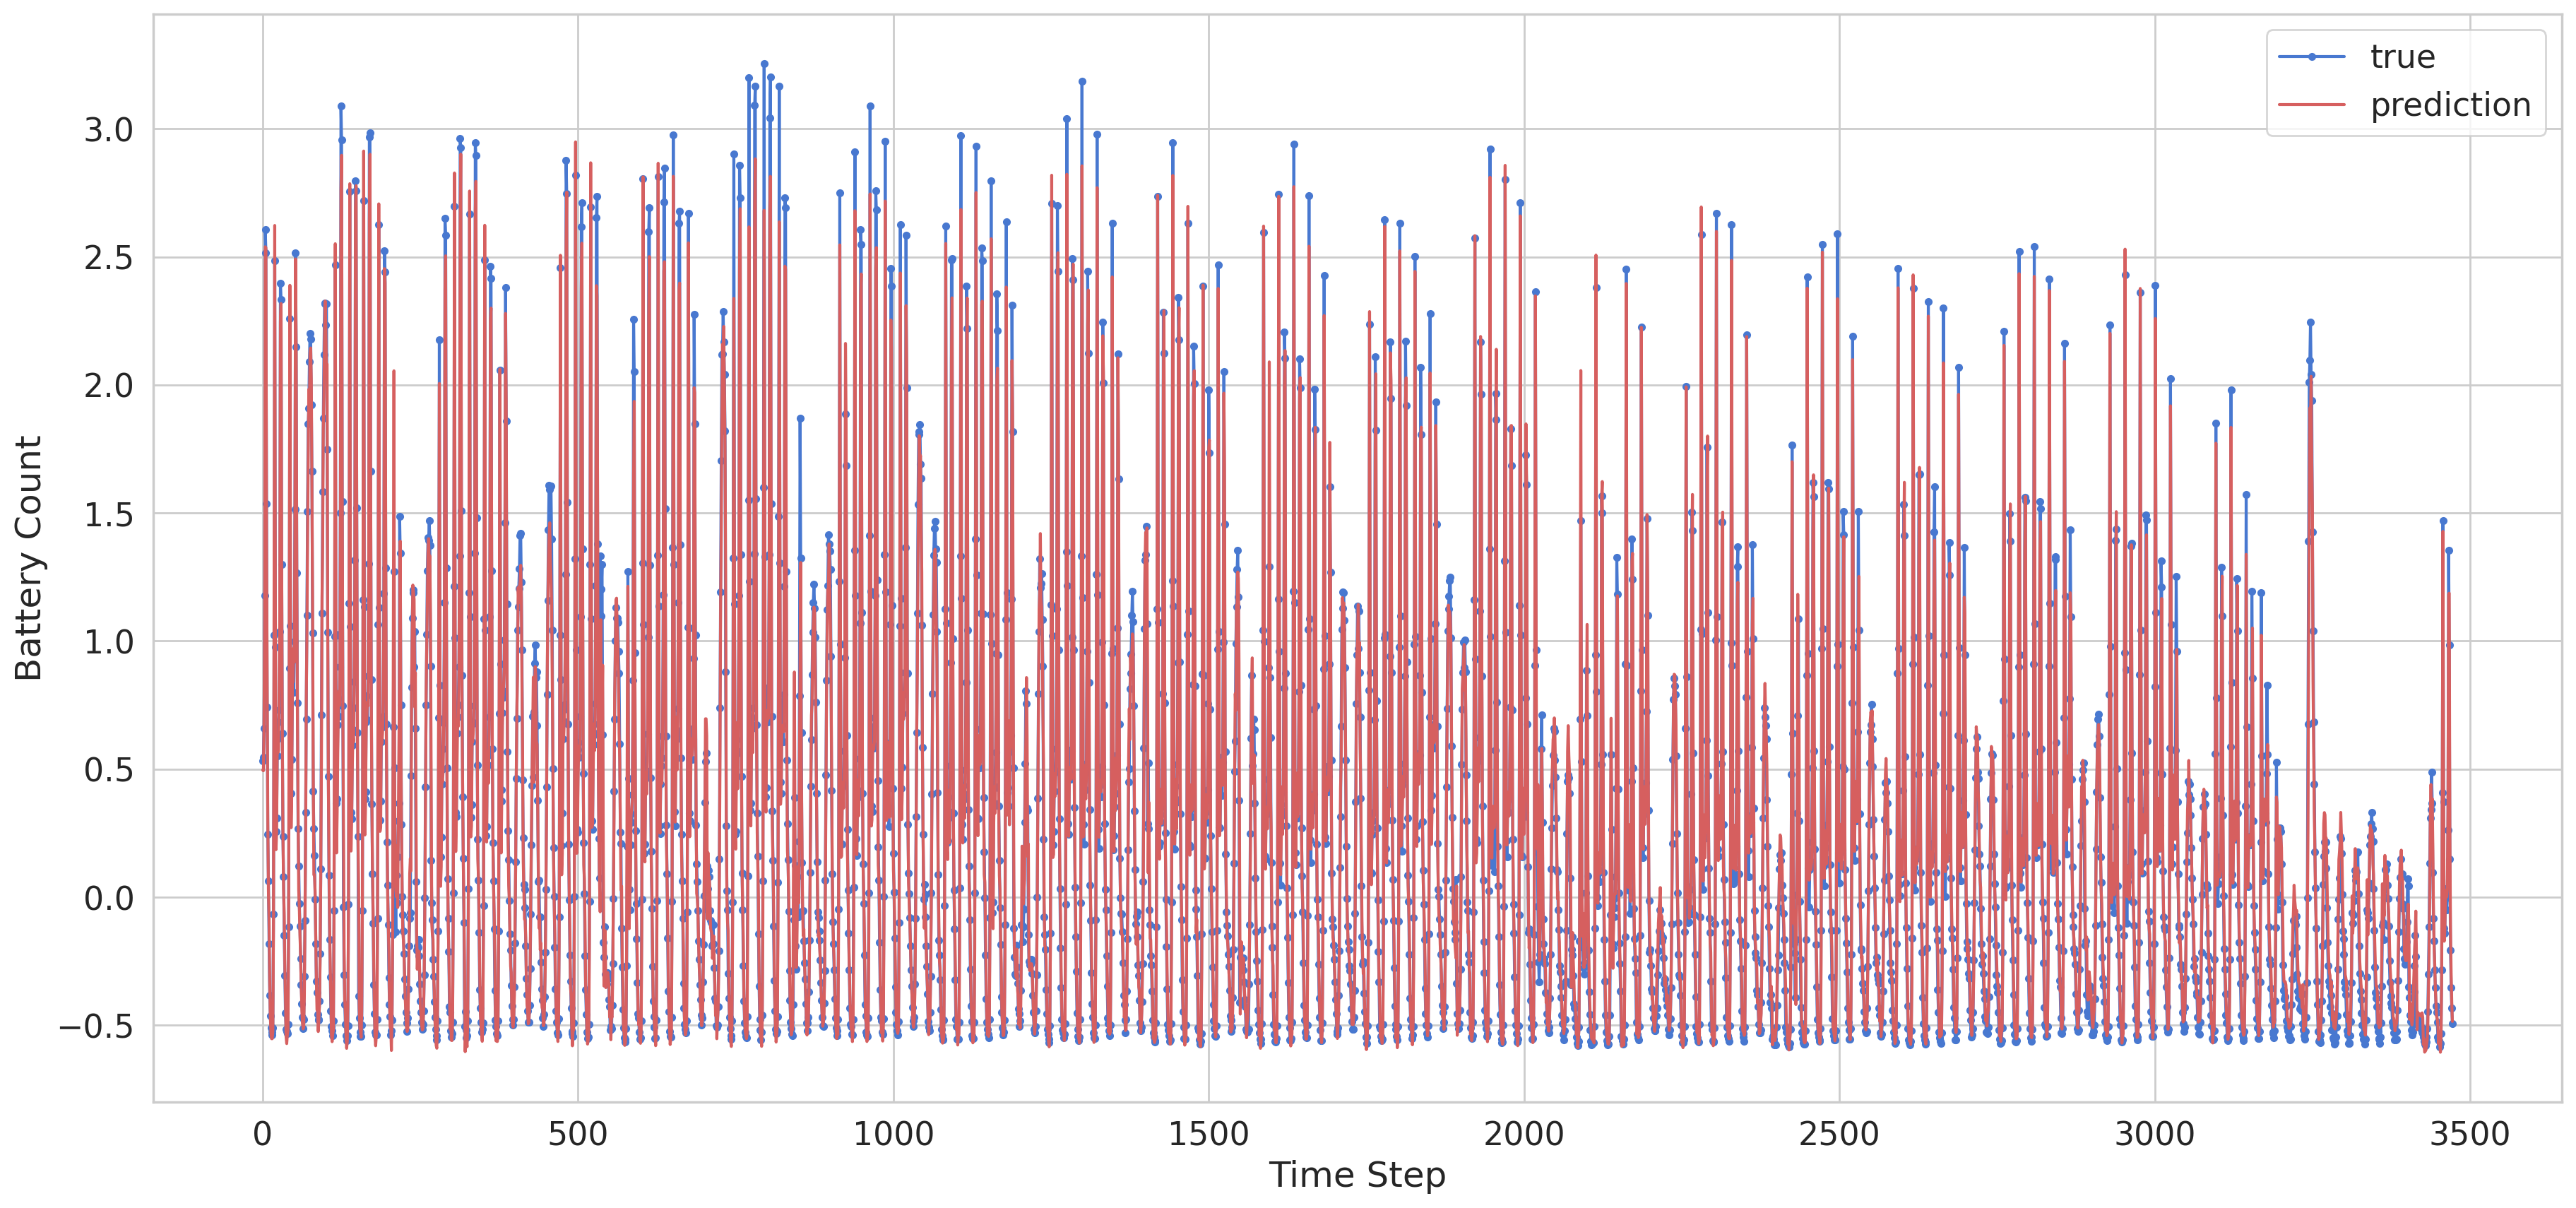

In [28]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot( y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Battery Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();